In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid")
import sys; sys.path.append("..")
from trader.data.binance import Binance
import mplfinance as mpf

In [2]:
#b = Binance(test=False)

In [3]:
SYMBOLS = ['BTCUSDT', 'ETHUSDT', 'DOGEUSDT', 'LINKUSDT', 'ADAUSDT']

In [110]:
bars = pd.read_csv("hour6.csv")
bars.CloseTime = pd.to_datetime(bars.CloseTime)
data = {s : bars[bars.Symbol == s].set_index("CloseTime")[["Open", "High", "Low", "Close", "QuoteVolume"]].groupby(pd.Grouper(freq="6H")).last() for s in SYMBOLS}
index = pd.date_range("2022-03-21", "2022-07-21", freq="6h")

In [111]:
bars

OpenTime        Open        High         Low       Close  \
0     2022-01-01 00:00:00  46216.9300  47555.5500  46208.3700  47192.5500   
1     2022-01-01 06:00:00  47192.5600  47344.6900  46715.3900  46758.8700   
2     2022-01-01 12:00:00  46758.8700  47954.6300  46756.3000  47754.4800   
3     2022-01-01 18:00:00  47754.4700  47844.9700  47222.2200  47722.6500   
4     2022-01-02 00:00:00  47722.6600  47750.0000  46770.2300  47081.2800   
...                   ...         ...         ...         ...         ...   
5260  2022-09-20 00:00:00      0.4527      0.4545      0.4440      0.4481   
5261  2022-09-20 06:00:00      0.4480      0.4517      0.4426      0.4446   
5262  2022-09-20 12:00:00      0.4445      0.4491      0.4373      0.4414   
5263  2022-09-20 18:00:00      0.4413      0.4449      0.4375      0.4422   
5264  2022-09-21 00:00:00      0.4423      0.4634      0.4415      0.4502   

            Volume           CloseTime   QuoteVolume  NumTrades  \
0     5.757825e+03 2022-01-01 06:00:00  2.695514e+08     179514   
1     3.989857e+03 2022-01-01 12:00:00  1.876498e+08     159760   
2     5.426154e+03 2022-01-01 18:00:00  2.566354e+08     195239   
3     4.430627e+03 2022-01-02 00:00:00  2.103185e+08     180386   
4     4.333799e+03 2022-01-02 06:00:00  2.049136e+08     162090   
...            ...                 ...           ...        ...   
5260  2.228493e+07 2022-09-20 06:00:00  9.992560e+06      21174   
5261  2.079912e+07 2022-09-20 12:00:00  9.282425e+06      20266   
5262  4.249106e+07 2022-09-20 18:00:00  1.882075e+07      40593   
5263  2.195473e+07 2022-09-21 00:00:00  9.695117e+06      21362   
5264  7.053777e+07 2022-09-21 06:00:00  3.211800e+07      64452   

      TakerBaseVolume  TakerQuoteVolue    Return   Symbol  
0        2.926201e+03     1.369881e+08       NaN  BTCUSDT  
1        1.901698e+03     8.944920e+07 -0.009190  BTCUSDT  
2        2.715858e+03     1.284503e+08  0.021292  BTCUSDT  
3        2.398609e+03     1.138510e+08 -0.000667  BTCUSDT  
4        2.119435e+03     1.002206e+08 -0.013440  BTCUSDT  
...               ...              ...       ...      ...  
5260     1.006533e+07     4.513762e+06 -0.010161  ADAUSDT  
5261     1.017131e+07     4.540999e+06 -0.007811  ADAUSDT  
5262     2.088794e+07     9.252068e+06 -0.007197  ADAUSDT  
5263     1.114522e+07     4.922141e+06  0.001812  ADAUSDT  
5264     3.628333e+07     1.652125e+07  0.018091  ADAUSDT  

[5265 rows x 13 columns]

In [132]:
def hlhl_breakout(bar, state, symbol, p=0.5):
    bar = bar.iloc[-6:-1]
    diff = bar.diff().iloc[1:]
    d12 = diff.iloc[:2]
    d3 = diff.iloc[2]
    d4 = diff.iloc[3]
    bar_fib = bar.iloc[4]
    if (d12.Low < 0).all() and (d12.High < 0).all(): #down trend
        if d3.High > 0: #breakout
            p = (bar_fib.Close - bar.iloc[2].Low) / (bar.iloc[3].High - bar.iloc[2].Low)
            if (p < 0.5) and (not has_positions[symbol]):
                state["old_highs"][symbol] = bar.iloc[3].High
                return 1
    elif bar_fib.Close > state["old_highs"][symbol]:
        return -1
    
def buyhold(bar, state, symbol):
    return 1

def breakout(bar, state):
    price = bar.Close.iloc[-31:-1]
    max_price = price.max()
    min_price = price.min()
    mean = (max_price + min_price) / 2
    signal = (price.iloc[-1] - mean) / (max_price - min_price)
    if signal > 0.3:
        return 1
    elif signal < -0.3:
        return -1
    
def meanrev(bar, state, s = 1.5):
    price = bar.Close.iloc[-31:-1]
    mean = price.mean()
    std = price.diff().std()
    if price.iloc[-1] > mean - std:
        return 1
    elif price.iloc[-1] < mean:
        return -1

In [133]:
def buy(symbol, amount):
    pass

In [145]:
cash = 100
holdings = {s : 0 for s in SYMBOLS}
has_positions = {s : False for s in SYMBOLS}
state = {}
state["old_highs"] = {s : 0 for s in SYMBOLS}
portfolio = pd.DataFrame(index=index, columns = SYMBOLS + ["USDT"])
signals = pd.DataFrame(index=index, columns = SYMBOLS, dtype=np.int16)
stop_loss_check = {k: np.nan for k in SYMBOLS}
for date in index:
    for symbol, df in data.items():
        df = df.loc[:date]
        close_last = df.Close.iloc[-1]
        
        signal = hlhl_breakout(df, state, symbol)
        #signal = buyhold(df, state, symbol)
        #signal = breakout(df, state)
        #signal = meanrev(df, state)
        if (signal == 1) and (not has_positions[symbol]):
            balance_quoted = cash
            buy_amount = balance_quoted / close_last / len(SYMBOLS)
            holdings[symbol] = buy_amount
            cash -= balance_quoted / len(SYMBOLS)
            signals.loc[date, symbol] = 1
            stop_loss_check[symbol] = close_last
            print(date, "BUY ", symbol, buy_amount)
            has_positions[symbol] = True
                    
        elif (signal == -1) and has_positions[symbol]:
            exit_amount = holdings[symbol]
            print(date, "SELL: ", symbol, exit_amount)
            has_positions[symbol] = False
            signals.loc[date, symbol] = - 1
            cash += exit_amount * close_last
            holdings[symbol] = 0
            #close_position(data.symbol)
        pos_pnl = close_last / stop_loss_check[symbol] - 1
        #print(symbol, pos_pnl, has_positions[symbol], close_last, stop_loss_check[symbol])
        if (pos_pnl < -0.1) and has_positions[symbol]:
            print("STOP LOSS ON ", symbol)
            exit_amount = holdings[symbol]
            has_positions[symbol] = False
            cash += exit_amount * close_last
            signals.loc[date, symbol] = - 1
            holdings[symbol] = 0
        portfolio.loc[date, symbol] = holdings[symbol]
    
    portfolio.loc[date, "USDT"] = cash

2022-03-26 06:00:00 BUY  DOGEUSDT 150.82956259426848
2022-03-27 12:00:00 SELL:  DOGEUSDT 150.82956259426848
2022-04-07 00:00:00 BUY  BTCUSDT 0.0004681011069923513
2022-04-08 00:00:00 BUY  DOGEUSDT 110.80545467514784
2022-04-08 12:00:00 SELL:  DOGEUSDT 110.80545467514784
2022-04-17 12:00:00 BUY  ADAUSDT 16.912045103088538
2022-04-20 18:00:00 SELL:  ADAUSDT 16.912045103088538
2022-04-25 00:00:00 BUY  ADAUSDT 18.187129316278508
STOP LOSS ON  BTCUSDT
2022-04-28 00:00:00 BUY  DOGEUSDT 118.04660604705575
STOP LOSS ON  ADAUSDT
2022-05-06 18:00:00 BUY  ETHUSDT 0.005981200283294593
2022-05-06 18:00:00 BUY  LINKUSDT 1.2075908457679678
STOP LOSS ON  DOGEUSDT
STOP LOSS ON  ETHUSDT
STOP LOSS ON  LINKUSDT
2022-05-18 18:00:00 BUY  BTCUSDT 0.0006337924752174194
2022-05-27 06:00:00 BUY  LINKUSDT 2.329191966781205
2022-05-27 12:00:00 BUY  DOGEUSDT 151.32253601430529
2022-05-28 06:00:00 BUY  ADAUSDT 20.386235020912913
2022-05-30 06:00:00 SELL:  ADAUSDT 20.386235020912913
2022-05-30 12:00:00 SELL:  DOGEUS

In [146]:
state

{'old_highs': {'BTCUSDT': 20762.02,
  'ETHUSDT': 1088.83,
  'DOGEUSDT': 0.0734,
  'LINKUSDT': 6.99,
  'ADAUSDT': 0.4536}}

In [147]:
close_last

0.491

In [148]:
stop_loss_check

{'BTCUSDT': 19956.82,
 'ETHUSDT': 1058.68,
 'DOGEUSDT': 0.0661,
 'LINKUSDT': 6.55,
 'ADAUSDT': 0.4349}

In [149]:
prices = bars.groupby(["CloseTime", "Symbol"]).Close.last().unstack()[SYMBOLS]
prices["USDT"] = 1

<AxesSubplot:>

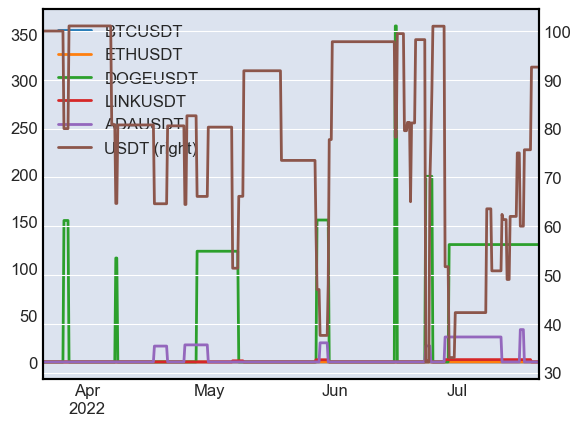

In [150]:
portfolio.plot(secondary_y="USDT")

In [154]:
pnl = (portfolio * prices.loc[portfolio.index].diff()).sum(axis=1).cumsum()

<AxesSubplot:>

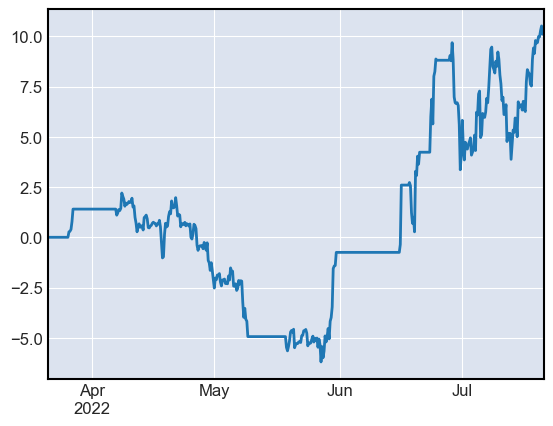

In [161]:
pnl.plot()

<AxesSubplot:>

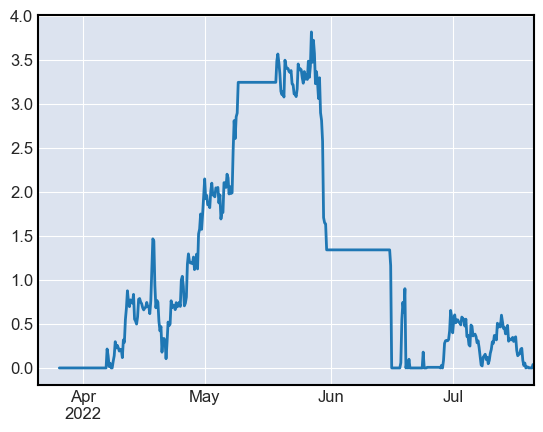

In [160]:
((pnl.cummax() - pnl) / pnl.cummax()).plot()

In [152]:
ss = "BTCUSDT"
buy = data[ss].Close * signals[ss] * 0.99
buy[buy < 0 ] = np.nan
sell = data[ss].Close * signals[ss] * 1.01
sell[sell > 0 ] = np.nan
apd = []
if buy.dropna().shape[0] > 0:
    apd.append(mpf.make_addplot(buy.loc[portfolio.index], scatter=True, markersize=200, marker=r'$\Uparrow$', color='green'))
if sell.dropna().shape[0] > 0:
    apd.append(mpf.make_addplot(sell.abs().loc[portfolio.index], scatter=True, markersize=200, marker=r'$\Downarrow$', color='red'))

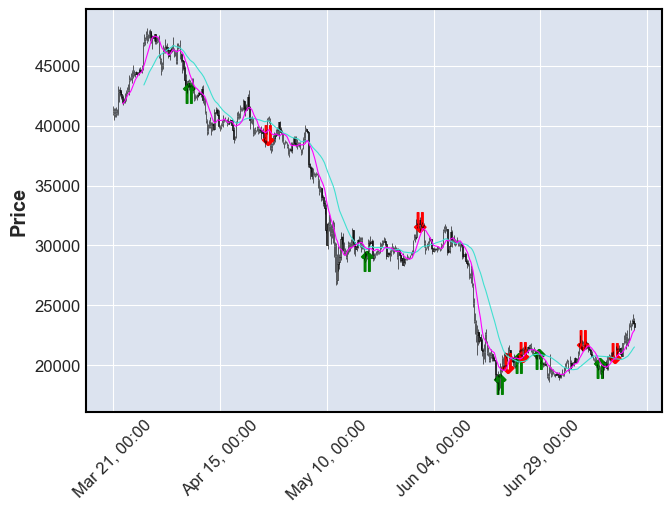

In [153]:
ax = mpf.plot(data[ss].loc[portfolio.index], type="candle", addplot=apd, mav=(30,10))

In [ ]:
mpf.plot

In [ ]:
cash

In [ ]:
holdings

In [ ]:
state